# The final evaluation on the test set 
Here we test RF, MTL and the self-trained MTL network on the 10% of data that have remained hidden in the test set. The previously labelled as training and validation sets now form a new train set.

## 0. Prerequisites

In [16]:
import numpy as np
import pandas as pd
import keras, os, pickle

from time import time
import  matplotlib.pyplot as plt
from sklearn.metrics import r2_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import sem
from scipy.stats import t as tstat

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import regularizers
from keras import Model
import keras.backend as K

np.random.seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [2]:
Interactions_train = []    
with open("Interactions_Trainset.tab",'r') as f:
    for line in f:
        tokens = line.split()
        # 'Target-ID', 'Compound-ID', 'pIC50'  
        Interactions_train.append( [tokens[0], tokens[1], float(tokens[2]) ])

Interactions_valid = []        
with open("Interactions_Validset.tab",'r') as f:
    for line in f:
        tokens = line.split()
        # 'Target-ID', 'Compound-ID', 'pIC50'  
        Interactions_valid.append( [tokens[0], tokens[1], float(tokens[2]) ])

Interactions = [x for x in Interactions_train]
Interactions.extend(Interactions_valid)
# we use a dataframe to quickly sort targets wrt #compounds:
DF = pd.DataFrame( Interactions, columns =['Target-ID', 'Compound-ID','Std-value']) 
temp = DF.groupby(['Target-ID']).agg('count').sort_values(by='Compound-ID') # count the number of molecules
Targets = list(temp.index)
Compounds = np.unique(DF['Compound-ID'])
del temp, DF, Interactions_train, Interactions_valid

nT=len(Targets); nC=len(Compounds)

print("There are {0} targets and {1} compounds currently loaded with {2} interactions.".format(nT,nC,len(Interactions)))
print("A DTI matrix would be {0:.4}% dense!".format(100.0*len(Interactions)/nT/nC ))

# first we need to prepare each fp as a feature vector
Fingerprints={} # this contains one list per fingerprint - not efficient...
with open('Compound_Fingerprints_155K.tab', 'r') as f:
    header = f.readline()
    for line in f:
        # each line is Comp-ID, SMILES, FP
        tokens = line.split()
        # we keep only those compounds which have FPs
        if tokens[2] != 'NOFP':
            fp = [int(c) for c in tokens[2] ]
            Fingerprints[ tokens[0] ] = fp
print("%d fingerprints were loaded!" % len(Fingerprints))

# data standardisation - no need after using pIC50 !
values = [x[2] for x in Interactions]
print("Stats for values : {0} | {1}".format(np.mean(values), np.std(values)))

There are 110 targets and 23167 compounds currently loaded with 56392 interactions.
A DTI matrix would be 2.213% dense!
155083 fingerprints were loaded!
Stats for values : 4.395417284295644 | 2.588704763200101


In [3]:
Interactions_test = [] # first time to load - no possibility for "data contamination"
with open("Interactions_Testset.tab", 'r') as file:
    header_line = next(file)
    for line in file:
        tokens =  line.split()
        Interactions_test.append( [tokens[0], tokens[1], float(tokens[2]) ])
Compounds_to_test = set( [x[1] for x in Interactions_test] )
print("Test set: {0} compounds and {1} interactions are loaded.".format(len(Compounds_to_test), len(Interactions_test)))

Test set: 5550 compounds and 6263 interactions are loaded.


In [4]:
def mulpredict(model, x_test, Ntargets, N=10, conf_flag=False):
    preds = np.zeros( (N, Ntargets) )
    for i in range(N):
        preds[i,:] = [ x[0][0] for x in model.predict( x_test ) ]
    # we need the column-wise average of this matrix
    if conf_flag:
        std_err = sem(preds, axis=0)
        h = std_err * tstat.ppf((1 + 0.95) / 2, len(preds) - 1)
        return np.mean(preds, axis=0), h
    else:
        return np.mean(preds, axis=0) 
    
def Evaluate(Inter_list, Comp_list, Model, Fingerprints, Ntar=110, Niter=10):
    
    Predictions = []
    Percomp = {} # contains dicts with lists: (target: [true, pred_NN] )
    for test_case in Comp_list:
        Percomp[ test_case ] = {}
        for tokens in Inter_list:
            if tokens[1]==test_case:
                # CID-TID -> [true_val]
                Percomp[test_case][ tokens[0] ] = [ tokens[2] ]
        if len(Percomp[ test_case ])>0:
            # we've got some values for this compound, now produce predictions:
            preds = mulpredict(Model, np.array( Fingerprints[test_case]).reshape(1,-1), Ntar, Niter)
            for target in Percomp[test_case]: 
                Percomp[test_case][target].append( preds[Labels_Targ[target]])
                Predictions.append( [target, test_case, Percomp[test_case][target][0], Percomp[test_case][target][1] ])

        if len(Predictions) % 1000 == 0:
            r2 = r2_score([x[2] for x in Predictions], [x[3] for x in Predictions])
            print(f"\rMore than ", len(Predictions)," predictions have been parsed. Mean performance so far =",r2, end=" ")
    print(" ")
    r2 = r2_score([x[2] for x in Predictions], [x[3] for x in Predictions])
    print("Performance for MTL-D NN = %f" % r2)
    return Predictions

def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 10), K.floatx())
    return keras.losses.mean_squared_error(y_true * mask, y_pred * mask)

def MTL(lamda=0.02, wsl=200, whl=20, lr=0.0001):
    inputs = keras.Input(shape=(2048,))
    sharedlayer = keras.layers.Dense(wsl, activation='tanh',kernel_regularizer=regularizers.l2(lamda) )(inputs) 
    myinit = keras.initializers.Constant(-4.)
    hidden = []
    for i in range(len(Targets)):
        hl = Dense(units=whl,  activation='tanh', kernel_regularizer=regularizers.l2(lamda) )(sharedlayer)
        hidden.append( Dense(1, kernel_initializer=myinit, activity_regularizer=regularizers.l1(0.0001) )(hl) )

    MTL=Model(inputs=inputs, outputs=hidden)
    MTL.compile(loss=masked_loss_function, optimizer=keras.optimizers.adam(lr=0.0001))
    return MTL

Labels_Targ = dict()
indx=0
for x in Targets:
    Labels_Targ[x]=indx
    indx+=1
    
Labels_Comp = dict()
indx=0
for x in Compounds:
    Labels_Comp[x]=indx
    indx+=1

## 1. Ranfom Forests

Models are ready. Duration so far = 177.43648552894592
Duration per 1000 predictions =  3.6758157595190286
Performance for RF = 0.678334


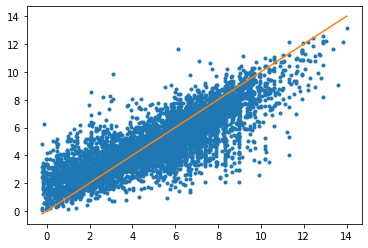

In [5]:
RF_all = {}; Y_pred = []; Y_true = []
Pertarget_RF = dict() # contains lists with tuples: (true, pred_RF, pred_NN)
Predictions_RF = [] # this will contain items as [target, compound, true, prediction]

t0=time()
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    # load pre-trained models:
    with open( 'ECFP/TrainedModels/RF_'+target+'_'+'pIC50new.sav', 'rb') as f:
        RFR = pickle.load( f )
    RFR.fit(X_train,Y_train)
    RF_all[target] = RFR
           
print("Models are ready. Duration so far =",time()-t0)
t0=time()
for tokens in Interactions_test:
    # 'Target-ID', 'Compound-ID', 'Std-value'  
    if tokens[1] in Fingerprints:
        Y_true.append( tokens[2] )
        x_test = np.array( Fingerprints[tokens[1]] ).reshape(1,-1) # prepare for prediction

        model = RF_all[tokens[0]]
        Y_pred.append( model.predict( x_test ) )
        Predictions_RF.append( [tokens[0], tokens[1], tokens[2], Y_pred[-1][0]] )

    if tokens[0] in Pertarget_RF:
        Pertarget_RF[tokens[0]].append( (Y_true[-1], Y_pred[-1][0])  )
    else:
        # first time for this protein
        Pertarget_RF[tokens[0]] = [ (Y_true[-1], Y_pred[-1][0]) ]
        
print("Duration per 1000 predictions = ",1000*(time()-t0)/len(Predictions_RF) )
print("Performance for RF = %f" % r2_score( Y_true, Y_pred ))
plt.plot(Y_true, Y_pred,'.')
plt.plot([min(Y_true), max(Y_true)], [min(Y_true), max(Y_true)])

## 2. MTL Approach

Loading pre-trained model...
More than  6000  predictions have been parsed. Mean performance so far = 0.6255036334325168  
Performance for MTL-D NN = 0.630332
Duration per 1000 predictions =  0.047549686697445186


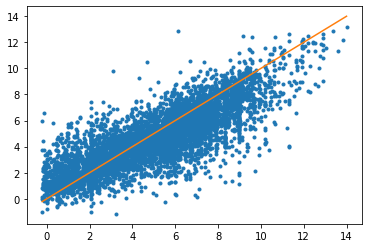

In [10]:
best_params = {'wsl': 200, 'whl': 30, 'lamda': 0.1}
wsl=best_params['wsl']; whl=best_params['whl']; lamda=best_params['lamda']

# Initialize sparse matrix - this will be binary
DTI = 10*np.ones((nC,nT),dtype=float)
for edge in Interactions:
    # each edge has "target-compound-value-active"
    DTI[ Labels_Comp[edge[1]], Labels_Targ[edge[0]] ] = edge[2]
    
if os.path.isfile('MTL-'+str(wsl)+'-'+str(whl)+'-'+str(lamda)+'-model.h5'):
    print("Loading pre-trained model...")
    MTLR = load_model('MTL-'+str(wsl)+'-'+str(whl)+'-'+str(lamda)+'-model.h5', compile=False)
else:  
    Nepochs = 30; BS=64
    t0=time()
    MTLR = MTL(wsl=wsl, whl=whl, lamda=lamda )
    MTLR.fit( np.array([Fingerprints[x] for x in Compounds]), [x for x in DTI.T], epochs=Nepochs, batch_size=BS, verbose=0, use_multiprocessing=True )
    print("Training length with {0} epochs and BS={1} is {2}".format(Nepochs, BS, time()-t0))
    
t0=time()
Predictions_MTL = Evaluate( Interactions_test, Compounds_to_test, MTLR, Fingerprints, Niter=1)
print("Duration per 1000 predictions = ",1000*(time()-t0)/len(Compounds_to_test)/len(Targets) )
Y_true = [x[2] for x in Predictions_MTL]; Y_pred = [x[3] for x in Predictions_MTL]
plt.plot(Y_true, Y_pred,'.')
plt.plot([min(Y_true), max(Y_true)], [min(Y_true), max(Y_true)])

# More than  6000  predictions have been parsed. Mean performance so far = 0.6255036334325168  
# Performance for MTL-D NN = 0.630332
# Duration per 1000 predictions =  0.49649681994214007

## 3. MTL with self-training



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



More than  6000  predictions have been parsed. Mean performance so far = 0.6557276051055569  
Performance for MTL-D NN = 0.659308
Duration per 1000 predictions =  0.3339298628667258


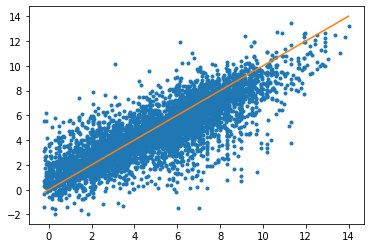

In [7]:
MTLDSF = load_model('MTLDSF-200-20-0.04.h5', compile=False) #, custom_objects={'masked_loss_function':masked_loss_function})

t0=time()
Predictions_MTLDSF = Evaluate( Interactions_test, Compounds_to_test, MTLDSF, Fingerprints)
print("Duration per 1000 predictions = ",1000*(time()-t0)/len(Compounds_to_test)/len(Targets) )
Y_true = [x[2] for x in Predictions_MTLDSF]; Y_pred = [x[3] for x in Predictions_MTLDSF]
plt.plot(Y_true, Y_pred,'.')
plt.plot([min(Y_true), max(Y_true)], [min(Y_true), max(Y_true)])

## Per target analysis

In [11]:
Scores_RF_pertarget = []
for target in Pertarget_RF:
    true=[]; pred=[]; 
    # aggregate predictions
    for point in Pertarget_RF[target]:
        true.append( point[0] )
        pred.append( point[1] )
    # calculate performance for each method
    r2 = r2_score(true, pred)
    Scores_RF_pertarget.append( r2 )
    
Pertarget_MTLDSF={}
for tokens in Predictions_MTLDSF:
    if tokens[0] in Pertarget_MTLDSF:
        Pertarget_MTLDSF[tokens[0]].append( (tokens[2], tokens[3])  )
    else:
        # first time for this protein
        Pertarget_MTLDSF[tokens[0]] = [ (tokens[2], tokens[3]) ]

Pertarget_MTL={}
for tokens in Predictions_MTL:
    if tokens[0] in Pertarget_MTL:
        Pertarget_MTL[tokens[0]].append( (tokens[2], tokens[3])  )
    else:
        # first time for this protein
        Pertarget_MTL[tokens[0]] = [ (tokens[2], tokens[3]) ]

Scores_MTL_pertarget = []

for target in Pertarget_MTL:
    true=[]; pred=[]; 
    # aggregate predictions
    for point in Pertarget_MTL[target]:
        true.append( point[0] )
        pred.append( point[1] )
    
    # calculate performance for each method
    r2 = r2_score(true, pred)
    Scores_MTL_pertarget.append( r2 )

Scores_MTLDSF_pertarget = []
for target in Pertarget_MTLDSF:
    true=[]; pred=[]; 
    # aggregate predictions
    for point in Pertarget_MTLDSF[target]:
        true.append( point[0] )
        pred.append( point[1] )
    
    # calculate performance for each method
    r2 = r2_score(true, pred)
    Scores_MTLDSF_pertarget.append( r2 )

In [12]:
print("Mean per target R2-score for RF = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_RF_pertarget), np.std(Scores_RF_pertarget) )) 
print("Mean per target R2-score for MTL = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_MTL_pertarget), np.std(Scores_MTL_pertarget) )) 
print("Mean per target R2-score for MTL with SF = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_MTLDSF_pertarget), np.std(Scores_MTLDSF_pertarget) )) 

Mean per target R2-score for RF = 0.5313 and std = 0.1925
Mean per target R2-score for MTL = 0.3831 and std = 0.3501
Mean per target R2-score for MTL with SF = 0.4915 and std = 0.2742


In [13]:
print( MSE([x[2] for x in Predictions_RF], [x[3] for x in Predictions_RF]) ) 
print( MSE([x[2] for x in Predictions_MTL], [x[3] for x in Predictions_MTL]) )
print( MSE([x[2] for x in Predictions_MTLDSF], [x[3] for x in Predictions_MTLDSF]) )

2.2537581529854758
2.5900848382192825
2.3870612700187066


#### Compare methods as if we had a classification task - just an insight

Normalized confusion matrix
[[0.93806411 0.06193589]
 [0.29016393 0.70983607]]
Normalized confusion matrix
[[0.93464052 0.06535948]
 [0.32721311 0.67278689]]
Normalized confusion matrix
[[0.92592593 0.07407407]
 [0.28098361 0.71901639]]


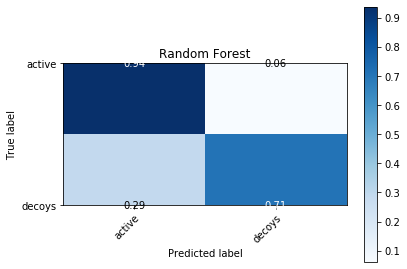

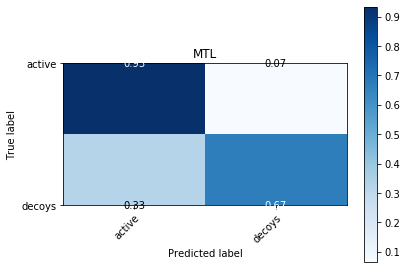

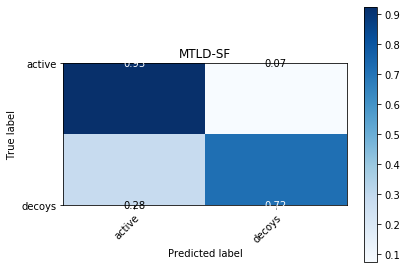

In [15]:
Class = []; Pred = []
for x in Predictions_RF:
    if x[2] > 9-np.log(30): Class.append(1) 
    else: Class.append(0)
    if x[3] > 9-np.log(30): Pred.append(1) 
    else: Pred.append(0)

# confusion_matrix(Class, Pred, labels=None)
plot_confusion_matrix(Class, Pred, ['active','decoys'], title='Random Forest', normalize=True)

Class = []; Pred = []
for x in Predictions_MTL:
    if x[2] > 9-np.log(30): Class.append(1) 
    else: Class.append(0)
    if x[3] > 9-np.log(30): Pred.append(1) 
    else: Pred.append(0)

# confusion_matrix(Class, Pred, labels=None)
plot_confusion_matrix(Class, Pred, ['active','decoys'], title='MTL', normalize=True)

# ind = np.where( [x[2] for x in Predictions_MTL] >-np.log(30) )[0]
Class = []; Pred = []
for x in Predictions_MTLDSF:
    if x[2] > 9-np.log(30): Class.append(1) 
    else: Class.append(0)
    if x[3] > 9-np.log(30): Pred.append(1) 
    else: Pred.append(0)

# confusion_matrix(Class, Pred, labels=None)
plot_confusion_matrix(Class, Pred, ['active','decoys'], title='MTLD-SF', normalize=True)